# Import library and DATA

In [ ]:
!pip install --quiet optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.4 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.model_selection import KFold

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
])

In [ ]:
batch_size = 128

In [ ]:
(x_train, y_train_sfm), (x_test, y_test_sfm) = tf.keras.datasets.cifar10.load_data()


# Normalize the pixel values between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train_svm = to_categorical(y_train_sfm)
y_test_svm = to_categorical(y_test_sfm)

# Apply data augmentation to the training dataset
train_dataset_svm = tf.data.Dataset.from_tensor_slices((x_train, y_train_svm))
train_dataset_svm = train_dataset_svm.shuffle(buffer_size=len(x_train))
train_dataset_svm = train_dataset_svm.map(lambda x, y: (data_augmentation(x), y))
train_dataset_svm = train_dataset_svm.batch(batch_size)

train_dataset_sfm = tf.data.Dataset.from_tensor_slices((x_train, y_train_sfm))
train_dataset_sfm = train_dataset_sfm.shuffle(buffer_size=len(x_train))
train_dataset_sfm = train_dataset_sfm.map(lambda x, y: (data_augmentation(x), y))
train_dataset_sfm = train_dataset_sfm.batch(batch_size)

170498071/170498071 [==============================] - 6s 0us/step


## CNN_Softmax

### Build model

In [ ]:
lr_sfm = 0.000167
wd_sfm = 0.000156

In [ ]:
model_softmax_cifar = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3072, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(wd_sfm)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax', name='softmax')
])

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_sfm)

In [ ]:
model_softmax_cifar.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

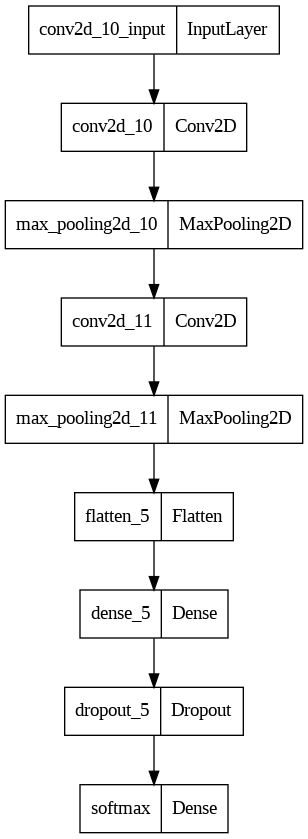

In [ ]:
tf.keras.utils.plot_model(model_softmax_cifar)

In [ ]:
history_sfm_cifar = model_softmax_cifar.fit(train_dataset_sfm, epochs=100, validation_data=(x_test, y_test_sfm))

Epoch 1/100
391/391 [==============================] - 41s 102ms/step - loss: 2.0399 - accuracy: 0.3415 - val_loss: 1.8058 - val_accuracy: 0.4187
Epoch 2/100
391/391 [==============================] - 38s 97ms/step - loss: 1.7843 - accuracy: 0.4205 - val_loss: 1.6386 - val_accuracy: 0.4670
Epoch 3/100
391/391 [==============================] - 37s 95ms/step - loss: 1.6854 - accuracy: 0.4499 - val_loss: 1.6279 - val_accuracy: 0.4689
Epoch 4/100
391/391 [==============================] - 38s 97ms/step - loss: 1.6083 - accuracy: 0.4733 - val_loss: 1.6300 - val_accuracy: 0.4689
Epoch 5/100
391/391 [==============================] - 38s 98ms/step - loss: 1.5534 - accuracy: 0.4921 - val_loss: 1.4856 - val_accuracy: 0.5051
Epoch 6/100
391/391 [==============================] - 39s 99ms/step - loss: 1.5010 - accuracy: 0.5097 - val_loss: 1.4672 - val_accuracy: 0.5128
Epoch 7/100
391/391 [==============================] - 39s 99ms/step - loss: 1.4546 - accuracy: 0.5256 - val_loss: 1.4114 - val_a

In [ ]:
history_sfm_cifar = model_softmax_cifar.history

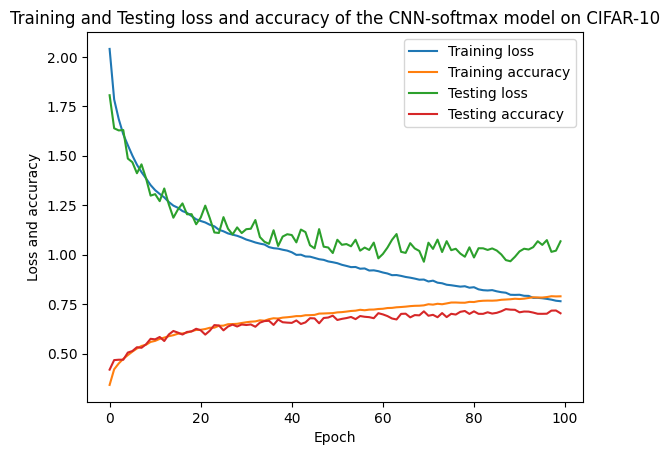

In [ ]:
plt.plot(history_sfm_cifar.history['loss'], label='Training loss')
plt.plot(history_sfm_cifar.history['accuracy'], label='Training accuracy')
plt.plot(history_sfm_cifar.history['val_loss'], label='Testing loss')
plt.plot(history_sfm_cifar.history['val_accuracy'], label='Testing accuracy')
plt.title('Training and Testing loss and accuracy of the CNN-softmax model on CIFAR-10')
plt.xlabel('Epoch')
plt.ylabel('Loss and accuracy')
plt.legend()
plt.savefig('Training loss and accuracy of the CNN-softmax model.png')
plt.show()

### Prediction

In [ ]:
# Make predictions using the loaded model
predictions_cifar_sfm = model_softmax_cifar.predict(x_test)

313/313 [==============================] - 1s 2ms/step


In [ ]:
y_pred_cifar_sfm = np.argmax(predictions_cifar_sfm, axis=-1)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_sfm, y_pred_cifar_sfm))

              precision    recall  f1-score   support

           0       0.77      0.78      0.78      1000
           1       0.73      0.89      0.80      1000
           2       0.77      0.49      0.60      1000
           3       0.59      0.49      0.54      1000
           4       0.69      0.59      0.64      1000
           5       0.71      0.54      0.62      1000
           6       0.53      0.91      0.67      1000
           7       0.80      0.74      0.77      1000
           8       0.86      0.80      0.83      1000
           9       0.72      0.80      0.75      1000

    accuracy                           0.70     10000
   macro avg       0.72      0.70      0.70     10000
weighted avg       0.72      0.70      0.70     10000



### Cross validation

In [ ]:
def objective_sfm(trial):
    lr = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    wd = trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
    k = 5
    kf = KFold(n_splits=k)

    # Train and evaluate model on each fold
    val_accs = []
    for train_idx, val_idx in kf.split(x_train):
      # Split data into train and validation sets
      x_train_fold, y_train_fold = x_train[train_idx], y_train_sfm[train_idx]
      x_val_fold, y_val_fold = x_train[val_idx], y_train_sfm[val_idx]
    # Build the model
      model_cross_sfm = tf.keras.Sequential([
          tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(32, 32, 3)),
          tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
          tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(3072, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(wd)),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(10, activation='softmax', name='softmax')
      ])
      
      # Compile the model
      print("the learning rate is ")
      print(lr)
      print("the Weight decay constant is ")
      print(wd)
      optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
      model_cross_sfm.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
      
      # Fit the model
      history = model_cross_sfm.fit(x_train_fold, y_train_fold, epochs=20, batch_size=128, validation_data=(x_val_fold, y_val_fold), verbose=1)
      
      # Evaluate model on current fold
      _, val_acc = model_cross_sfm.evaluate(x_val_fold, y_val_fold, verbose=1)
      val_accs.append(val_acc)

    # Return average validation accuracy across all folds
    return sum(val_accs) / len(val_accs)




In [ ]:
# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective_sfm, n_trials=10)
print('Best hyperparameters: ', study.best_params)
print('Best test set accuracy: ', study.best_value)

Best hyperparameters:  
learning_rate: 0.0001671750983017145

weight_decay: 0.00015584880882381504

Best test set accuracy:  0.6934399962425232

## CNN_SVM

### Build model

In [ ]:
lr_svm = 0.00124
L2_svm = 0.000141

In [ ]:
model_svm_cifar = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3072, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='linear', use_bias=False, name='svm')
])

In [ ]:
def l2_svm_loss(y_true, y_pred):
    # Replace 0 with -1 in y_true
    y_true = tf.where(tf.equal(y_true, 0), -tf.ones_like(y_true), y_true)
    
    # Compute hinge loss
    hinge_loss = L2_svm * tf.reduce_mean(tf.square(tf.maximum(0., 1. - y_true * y_pred)))
    
    # Compute L2 regularization term
    l2_reg_term = 0.5 * tf.reduce_sum(tf.matmul(tf.transpose(model_svm_cifar.get_layer('svm').kernel), model_svm_cifar.get_layer('svm').kernel))
    
    # Add hinge loss and L2 regularization term
    return hinge_loss + l2_reg_term

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_svm)

In [ ]:
model_svm_cifar.compile(optimizer=optimizer,
              loss=l2_svm_loss,
              metrics=['accuracy'])

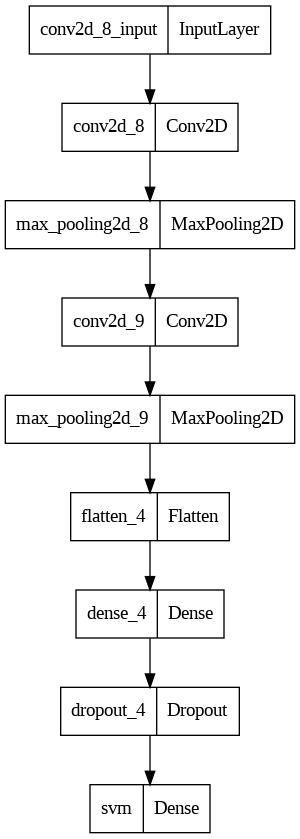

In [ ]:
tf.keras.utils.plot_model(model_svm_cifar)

In [ ]:
history_svm_cifar = model_svm_cifar.fit(train_dataset_svm, epochs=100, verbose=1, validation_data=(x_test, y_test_svm))

Epoch 1/100
391/391 [==============================] - 40s 98ms/step - loss: 0.1234 - accuracy: 0.2124 - val_loss: 1.3596e-04 - val_accuracy: 0.3267
Epoch 2/100
391/391 [==============================] - 38s 97ms/step - loss: 1.3475e-04 - accuracy: 0.3449 - val_loss: 1.3195e-04 - val_accuracy: 0.3863
Epoch 3/100
391/391 [==============================] - 41s 105ms/step - loss: 1.3241e-04 - accuracy: 0.3947 - val_loss: 1.2946e-04 - val_accuracy: 0.4409
Epoch 4/100
391/391 [==============================] - 44s 112ms/step - loss: 1.3998e-04 - accuracy: 0.4243 - val_loss: 1.4375e-04 - val_accuracy: 0.4721
Epoch 5/100
391/391 [==============================] - 39s 99ms/step - loss: 1.4751e-04 - accuracy: 0.4514 - val_loss: 1.5907e-04 - val_accuracy: 0.4962
Epoch 6/100
391/391 [==============================] - 38s 97ms/step - loss: 1.5276e-04 - accuracy: 0.4800 - val_loss: 1.5574e-04 - val_accuracy: 0.5217
Epoch 7/100
391/391 [==============================] - 39s 99ms/step - loss: 1.5785e

In [ ]:
model_svm_cifar.save('/content/drive/MyDrive/model_svm_cifar')

In [ ]:
history_svm_cifar = model_svm_cifar.history

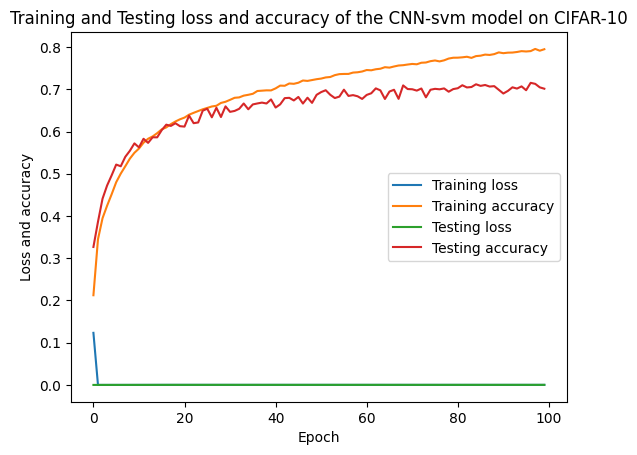

In [ ]:
plt.plot(history_svm_cifar.history['loss'], label='Training loss')
plt.plot(history_svm_cifar.history['accuracy'], label='Training accuracy')
plt.plot(history_svm_cifar.history['val_loss'], label='Testing loss')
plt.plot(history_svm_cifar.history['val_accuracy'], label='Testing accuracy')
plt.title('Training and Testing loss and accuracy of the CNN-svm model on CIFAR-10')
plt.xlabel('Epoch')
plt.ylabel('Loss and accuracy')
plt.legend()
plt.savefig('Training and Testing loss and accuracy of the CNN-svm model.png')
plt.show()

### Prediction


In [ ]:
# Make predictions using the loaded model
predictions_cifar_svm = model_svm_cifar.predict(x_test)

313/313 [==============================] - 1s 2ms/step


In [ ]:
y_pred_cifar_svm = np.argmax(predictions_cifar_svm, axis=-1)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_sfm, y_pred_cifar_svm))

              precision    recall  f1-score   support

           0       0.74      0.77      0.76      1000
           1       0.77      0.86      0.81      1000
           2       0.75      0.51      0.61      1000
           3       0.65      0.38      0.48      1000
           4       0.71      0.57      0.63      1000
           5       0.66      0.62      0.64      1000
           6       0.62      0.88      0.73      1000
           7       0.68      0.82      0.75      1000
           8       0.88      0.76      0.82      1000
           9       0.62      0.85      0.72      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.69     10000
weighted avg       0.71      0.70      0.69     10000



### Cross validation

In [ ]:
def objective_svm(trial):
    lr = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    C = trial.suggest_loguniform('C', 1e-5, 1e-1)
    k = 5
    kf = KFold(n_splits=k)
    def l2_svm_loss(y_true, y_pred):
        # Replace 0 with -1 in y_true
        y_true = tf.where(tf.equal(y_true, 0), -tf.ones_like(y_true), y_true)
        
        # Compute hinge loss
        hinge_loss = C * tf.reduce_mean(tf.square(tf.maximum(0., 1. - y_true * y_pred)))
        
        # Compute L2 regularization term
        l2_reg_term = 0.5 * tf.reduce_sum(tf.matmul(tf.transpose(model_cross_svm.get_layer('svm').kernel), model_cross_svm.get_layer('svm').kernel))
        
        # Add hinge loss and L2 regularization term
        return hinge_loss + l2_reg_term
    # Train and evaluate model on each fold
    val_accs = []
    for train_idx, val_idx in kf.split(x_train):
      # Split data into train and validation sets
      x_train_fold, y_train_fold = x_train[train_idx], y_train_svm[train_idx]
      x_val_fold, y_val_fold = x_train[val_idx], y_train_svm[val_idx]
    # Build the model
      model_cross_svm = tf.keras.Sequential([
          tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(32, 32, 3)),
          tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
          tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(3072, activation='relu'),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(10, activation='linear', use_bias=False, name='svm')
      ])
      
      # Compile the model
      print("the learning rate is ")
      print(lr)
      print("the C constant is ")
      print(C)
      optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
      model_cross_svm.compile(optimizer=optimizer, loss=l2_svm_loss, metrics=['accuracy'])
      
      # Fit the model
      history = model_cross_svm.fit(x_train_fold, y_train_fold, epochs=20, batch_size=128, validation_data=(x_val_fold, y_val_fold), verbose=1)
      
      # Evaluate model on current fold
      _, val_acc = model_cross_svm.evaluate(x_val_fold, y_val_fold, verbose=1)
      val_accs.append(val_acc)

    # Return average validation accuracy across all folds
    return sum(val_accs) / len(val_accs)




In [ ]:
# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective_svm, n_trials=10)
print('Best hyperparameters: ', study.best_params)
print('Best test set accuracy: ', study.best_value)

Best hyperparameters:

learning_rate: 0.0012350451857829205, 

C: 0.00014136466481000368

Best test set accuracy:  0.7115399956703186

##CNN_SVM2

In [ ]:
# Define the L2-SVM model
l2svm_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(32,32,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3072, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, kernel_regularizer=tf.keras.regularizers.l2(l2=0.01), activation = 'linear', name='svm')
])

In [ ]:
# Define the initial and final learning rates, as well as the number of epochs to train for
lr_init = 1e-3
lr_final = 0.0
epochs = 50

lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(lr_init, epochs, end_learning_rate=lr_final, power=1.0)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Define a function that computes the learning rate for a given epoch
def lr_scheduler(epoch):
    # Compute the linearly decaying learning rate for this epoch
    lr = lr_init - (epoch / epochs) * (lr_init - lr_final)
    return lr

# Define the callbacks to be used during training, including the learning rate scheduler
callbacks = [
    tf.keras.callbacks.LearningRateScheduler(lr_scheduler),
    # add any other callbacks here
]

In [ ]:
# Compile the L2-SVM model
l2svm_model.compile(optimizer='adam',
                    loss='squared_hinge',
                    metrics=['accuracy'])

In [ ]:
l2svm_model.summary()

Separate the training dataset into 45000 and 5000 for training and validation

In [ ]:
training_set = train_dataset_svm.take(45000)
validation_set = train_dataset_svm.skip(len(x_train) - 5000).take(5000)

In [ ]:
validation_set

In [ ]:
history = l2svm_model.fit(training_set, epochs=10,
                validation_data = validation_set,
                batch_size=128
                )

In [ ]:
# Train the L2-SVM model using the training data and validation data
l2svm_model.fit(train_dataset_svm, epochs=10,
                batch_size=128
                )

Epoch 1/10
391/391 [==============================] - 44s 107ms/step - loss: 0.3512 - accuracy: 0.3234
Epoch 2/10
391/391 [==============================] - 41s 105ms/step - loss: 0.3010 - accuracy: 0.4157
Epoch 3/10
391/391 [==============================] - 42s 106ms/step - loss: 0.2882 - accuracy: 0.4485
Epoch 4/10
391/391 [==============================] - 41s 104ms/step - loss: 0.2774 - accuracy: 0.4809
Epoch 5/10
391/391 [==============================] - 42s 107ms/step - loss: 0.2688 - accuracy: 0.5041
Epoch 6/10
391/391 [==============================] - 41s 104ms/step - loss: 0.2610 - accuracy: 0.5229
Epoch 7/10
391/391 [==============================] - 41s 104ms/step - loss: 0.2546 - accuracy: 0.5393
Epoch 8/10
391/391 [==============================] - 41s 105ms/step - loss: 0.2486 - accuracy: 0.5528
Epoch 9/10
391/391 [==============================] - 41s 105ms/step - loss: 0.2448 - accuracy: 0.5624
Epoch 10/10
391/391 [==============================] - 42s 106ms/step - l

In [ ]:
l2svm_model.fit(train_dataset_svm, epochs=30,
                batch_size=128
                )

Epoch 1/30
391/391 [==============================] - 41s 105ms/step - loss: 0.2361 - accuracy: 0.5840
Epoch 2/30
391/391 [==============================] - 43s 110ms/step - loss: 0.2334 - accuracy: 0.5953
Epoch 3/30
391/391 [==============================] - 41s 104ms/step - loss: 0.2307 - accuracy: 0.5994
Epoch 4/30
391/391 [==============================] - 42s 107ms/step - loss: 0.2277 - accuracy: 0.6051
Epoch 5/30
391/391 [==============================] - 41s 104ms/step - loss: 0.2253 - accuracy: 0.6104
Epoch 6/30
391/391 [==============================] - 41s 104ms/step - loss: 0.2220 - accuracy: 0.6178
Epoch 7/30
391/391 [==============================] - 41s 104ms/step - loss: 0.2202 - accuracy: 0.6228
Epoch 8/30
391/391 [==============================] - 41s 105ms/step - loss: 0.2187 - accuracy: 0.6247
Epoch 9/30
391/391 [==============================] - 42s 108ms/step - loss: 0.2162 - accuracy: 0.6311
Epoch 10/30
391/391 [==============================] - 42s 108ms/step - l

In [ ]:
l2svm_model.fit(train_dataset_svm, epochs=30,
                batch_size=128
                )

Epoch 1/30
391/391 [==============================] - 41s 105ms/step - loss: 0.1890 - accuracy: 0.6939
Epoch 2/30
391/391 [==============================] - 41s 105ms/step - loss: 0.1877 - accuracy: 0.6944
Epoch 3/30
391/391 [==============================] - 41s 104ms/step - loss: 0.1874 - accuracy: 0.6948
Epoch 4/30
391/391 [==============================] - 41s 104ms/step - loss: 0.1867 - accuracy: 0.6982
Epoch 5/30
391/391 [==============================] - 41s 105ms/step - loss: 0.1853 - accuracy: 0.7001
Epoch 6/30
391/391 [==============================] - 42s 106ms/step - loss: 0.1854 - accuracy: 0.6992
Epoch 7/30
391/391 [==============================] - 42s 107ms/step - loss: 0.1841 - accuracy: 0.7038
Epoch 8/30
391/391 [==============================] - 40s 103ms/step - loss: 0.1834 - accuracy: 0.7057
Epoch 9/30
391/391 [==============================] - 42s 106ms/step - loss: 0.1823 - accuracy: 0.7046
Epoch 10/30
391/391 [==============================] - 41s 105ms/step - l

In [ ]:
l2svm_model.fit(train_dataset_svm, epochs=30,
                batch_size=128
                )

Epoch 1/30
391/391 [==============================] - 41s 105ms/step - loss: 0.1710 - accuracy: 0.7297
Epoch 2/30
391/391 [==============================] - 41s 105ms/step - loss: 0.1712 - accuracy: 0.7304
Epoch 3/30
391/391 [==============================] - 41s 105ms/step - loss: 0.1684 - accuracy: 0.7362
Epoch 4/30
391/391 [==============================] - 41s 105ms/step - loss: 0.1694 - accuracy: 0.7352
Epoch 5/30
391/391 [==============================] - 42s 106ms/step - loss: 0.1692 - accuracy: 0.7354
Epoch 6/30
391/391 [==============================] - 40s 103ms/step - loss: 0.1691 - accuracy: 0.7332
Epoch 7/30
391/391 [==============================] - 41s 104ms/step - loss: 0.1678 - accuracy: 0.7371
Epoch 8/30
391/391 [==============================] - 42s 108ms/step - loss: 0.1688 - accuracy: 0.7343
Epoch 9/30
391/391 [==============================] - 41s 104ms/step - loss: 0.1671 - accuracy: 0.7409
Epoch 10/30
391/391 [==============================] - 41s 105ms/step - l

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.legend()
plt.show()

# MNIST

In [ ]:
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Load the MNIST dataset
(x_train, y_train_sfm), (x_test, y_test_sfm) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Vectorize the input data
x_train = np.reshape(x_train, (x_train.shape[0], -1))
x_test = np.reshape(x_test, (x_test.shape[0], -1))
y_train_svm = to_categorical(y_train_sfm)
y_test_svm = to_categorical(y_test_sfm)

# Initialize PCA object and fit on the training data
pca = PCA(n_components=70)
pca.fit(x_train)

# Transform the training and testing data using PCA
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)


In [ ]:
from keras.layers import GaussianNoise, Dense
from keras.callbacks import LearningRateScheduler, LambdaCallback
from keras.regularizers import l2
from keras.losses import SquaredHinge
from keras.optimizers import SGD

# SOFTMAX Regularization on every layer

In [ ]:
softmax_model = tf.keras.Sequential([
    GaussianNoise(1.0, input_shape=(70,)),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(l2=0.001)),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(l2=0.001)), 
    tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=l2(l2=0.001), name='softmax')
])

In [ ]:
optimizer = SGD(lr=0.1, momentum=0.9, nesterov=True)
softmax_model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer, metrics=['accuracy'])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
def lr_schedule(epoch):
    lr = 0.1 - (0.1 / 400) * (epoch)
    return lr

learning_rate = LearningRateScheduler(lr_schedule)

In [ ]:
from keras.callbacks import Callback
class GaussianNoiseDecay(Callback):
    def __init__(self, max_epochs, stddev_start=1.0, stddev_end=0.0):
        super(GaussianNoiseDecay, self).__init__()
        self.max_epochs = max_epochs
        self.stddev_start = stddev_start
        self.stddev_end = stddev_end

    def on_epoch_begin(self, epoch, logs=None):
        progress = epoch / self.max_epochs
        stddev = (1 - progress) * self.stddev_start + progress * self.stddev_end
        self.model.layers[0].stddev = stddev
        print(f"stddev: {stddev:.4f}")

In [ ]:
noise_callback = GaussianNoiseDecay(400)

In [ ]:
history = softmax_model.fit(x_train_pca, y_train_svm,
                epochs=400, 
                batch_size=200,
                validation_data=(x_test_pca, y_test_svm), 
                verbose=1,
                callbacks=[learning_rate, noise_callback])


stddev: 1.0000
Epoch 1/400
300/300 [==============================] - 6s 19ms/step - loss: 1.1653 - accuracy: 0.7698 - val_loss: 0.5312 - val_accuracy: 0.9453 - lr: 0.1000
stddev: 0.9975
Epoch 2/400
300/300 [==============================] - 4s 14ms/step - loss: 0.8096 - accuracy: 0.8148 - val_loss: 0.4013 - val_accuracy: 0.9498 - lr: 0.0997
stddev: 0.9950
Epoch 3/400
300/300 [==============================] - 5s 16ms/step - loss: 0.7320 - accuracy: 0.8182 - val_loss: 0.3672 - val_accuracy: 0.9553 - lr: 0.0995
stddev: 0.9925
Epoch 4/400
300/300 [==============================] - 5s 18ms/step - loss: 0.6994 - accuracy: 0.8254 - val_loss: 0.3466 - val_accuracy: 0.9545 - lr: 0.0993
stddev: 0.9900
Epoch 5/400
300/300 [==============================] - 4s 13ms/step - loss: 0.6884 - accuracy: 0.8270 - val_loss: 0.3522 - val_accuracy: 0.9492 - lr: 0.0990
stddev: 0.9875
Epoch 6/400
300/300 [==============================] - 4s 14ms/step - loss: 0.6794 - accuracy: 0.8303 - val_loss: 0.3655 - va

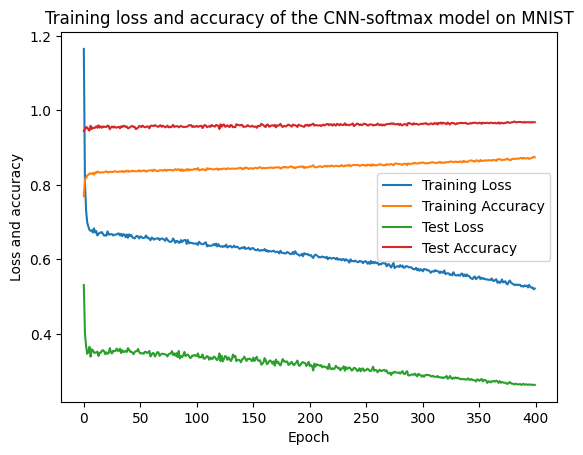

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')

plt.plot(history.history['val_loss'], label='Test Loss')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')

plt.title('Training loss and accuracy of the CNN-softmax model on MNIST')
plt.xlabel('Epoch')
plt.ylabel('Loss and accuracy')
plt.legend()
plt.savefig('MNIST-softmax.png')
plt.show()

In [ ]:
# Evaluate the model on the test data
score = softmax_model.evaluate(x_test_pca, y_test_svm, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2630823850631714
Test accuracy: 0.9684000015258789


# SOFTMAX Regularization on the final layer

## fine tune not needed

## implemention

In [ ]:
softmax_model = tf.keras.Sequential([
    GaussianNoise(1.0, input_shape=(70,)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=l2(l2=0.001), name='softmax')
])

In [ ]:
optimizer = SGD(lr=0.1, momentum=0.9, nesterov=True)
softmax_model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer, metrics=['accuracy'])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
def lr_schedule(epoch):
    lr = 0.1 - (0.1 / 400) * (epoch)
    return lr

learning_rate = LearningRateScheduler(lr_schedule)

In [ ]:
from keras.callbacks import Callback
class GaussianNoiseDecay(Callback):
    def __init__(self, max_epochs, stddev_start=1.0, stddev_end=0.0):
        super(GaussianNoiseDecay, self).__init__()
        self.max_epochs = max_epochs
        self.stddev_start = stddev_start
        self.stddev_end = stddev_end

    def on_epoch_begin(self, epoch, logs=None):
        progress = epoch / self.max_epochs
        stddev = (1 - progress) * self.stddev_start + progress * self.stddev_end
        self.model.layers[0].stddev = stddev
        print(f"stddev: {stddev:.4f}")

In [ ]:
noise_callback = GaussianNoiseDecay(400)

In [ ]:
history = softmax_model.fit(x_train_pca, y_train_svm,
                epochs=400, 
                batch_size=200,
                validation_data=(x_test_pca, y_test_svm), 
                verbose=1,
                callbacks=[learning_rate, noise_callback])


stddev: 1.0000
Epoch 1/400
300/300 [==============================] - 6s 19ms/step - loss: 0.7082 - accuracy: 0.7708 - val_loss: 0.2147 - val_accuracy: 0.9486 - lr: 0.1000
stddev: 0.9975
Epoch 2/400
300/300 [==============================] - 5s 18ms/step - loss: 0.5569 - accuracy: 0.8205 - val_loss: 0.1828 - val_accuracy: 0.9559 - lr: 0.0997
stddev: 0.9950
Epoch 3/400
300/300 [==============================] - 6s 21ms/step - loss: 0.5213 - accuracy: 0.8349 - val_loss: 0.1644 - val_accuracy: 0.9586 - lr: 0.0995
stddev: 0.9925
Epoch 4/400
300/300 [==============================] - 5s 17ms/step - loss: 0.5107 - accuracy: 0.8381 - val_loss: 0.1507 - val_accuracy: 0.9615 - lr: 0.0993
stddev: 0.9900
Epoch 5/400
300/300 [==============================] - 9s 30ms/step - loss: 0.4964 - accuracy: 0.8421 - val_loss: 0.1445 - val_accuracy: 0.9632 - lr: 0.0990
stddev: 0.9875
Epoch 6/400
300/300 [==============================] - 7s 24ms/step - loss: 0.4824 - accuracy: 0.8470 - val_loss: 0.1463 - va

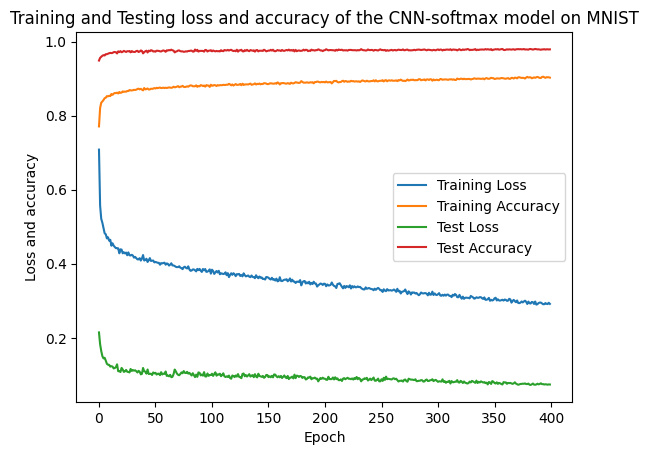

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')

plt.plot(history.history['val_loss'], label='Test Loss')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')

plt.title('Training and Testing loss and accuracy of the CNN-softmax model on MNIST')
plt.xlabel('Epoch')
plt.ylabel('Loss and accuracy')
plt.legend()
plt.savefig('MNIST-softmax.png')
plt.show()

In [ ]:
# Evaluate the model on the test data
score = softmax_model.evaluate(x_test_pca, y_test_svm, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.07411085814237595
Test accuracy: 0.9787999987602234


## Prediction

In [ ]:
# Make predictions using the loaded model
predictions_mnist_sfm = softmax_model.predict(x_test_pca)

313/313 [==============================] - 1s 2ms/step


In [ ]:
y_pred_mnist_sfm = np.argmax(predictions_mnist_sfm, axis=-1)

In [ ]:
y_pred_mnist_sfm

array([7, 2, 1, ..., 4, 5, 6])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test_svm, axis=-1), y_pred_mnist_sfm))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.96      1.00      0.98      1135
           2       0.99      0.98      0.98      1032
           3       0.99      0.98      0.98      1010
           4       0.99      0.96      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.99      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.99      0.98      0.98       974
           9       0.96      0.97      0.96      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



# SVM

### softmax activation

In [ ]:
l2svm_model = tf.keras.Sequential([
    GaussianNoise(1.0, input_shape=(70,)),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(l2=0.003)),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(l2=0.003)), 
    tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=l2(l2=0.003), name='svm')
])

In [ ]:
optimizer = SGD(lr=0.1, momentum=0.9, nesterov=True)
l2svm_model.compile(loss='squared_hinge', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
def lr_schedule(epoch):
    lr = 0.1 - (0.1 / 400) * (epoch)
    return lr

learning_rate = LearningRateScheduler(lr_schedule)

In [ ]:
from keras.callbacks import Callback
class GaussianNoiseDecay(Callback):
    def __init__(self, max_epochs, stddev_start=1.0, stddev_end=0.0):
        super(GaussianNoiseDecay, self).__init__()
        self.max_epochs = max_epochs
        self.stddev_start = stddev_start
        self.stddev_end = stddev_end

    def on_epoch_begin(self, epoch, logs=None):
        progress = epoch / self.max_epochs
        stddev = (1 - progress) * self.stddev_start + progress * self.stddev_end
        self.model.layers[0].stddev = stddev
        print(f"stddev: {stddev:.4f}")

In [ ]:
noise_callback = GaussianNoiseDecay(400)

In [ ]:
history = l2svm_model.fit(x_train_pca, y_train_svm,
                epochs=400, 
                batch_size=200,
                validation_data=(x_test_pca, y_test_svm), 
                verbose=1,
                callbacks=[learning_rate, noise_callback])


stddev: 1.0000
Epoch 1/400
300/300 [==============================] - 6s 18ms/step - loss: 1.7785 - accuracy: 0.2092 - val_loss: 1.0344 - val_accuracy: 0.8313 - lr: 0.1000
stddev: 0.9975
Epoch 2/400
300/300 [==============================] - 4s 14ms/step - loss: 0.9691 - accuracy: 0.9149 - val_loss: 0.9475 - val_accuracy: 0.9426 - lr: 0.0997
stddev: 0.9950
Epoch 3/400
300/300 [==============================] - 5s 16ms/step - loss: 0.9499 - accuracy: 0.9354 - val_loss: 0.9474 - val_accuracy: 0.9418 - lr: 0.0995
stddev: 0.9925
Epoch 4/400
300/300 [==============================] - 5s 16ms/step - loss: 0.9473 - accuracy: 0.9393 - val_loss: 0.9421 - val_accuracy: 0.9517 - lr: 0.0993
stddev: 0.9900
Epoch 5/400
300/300 [==============================] - 4s 14ms/step - loss: 0.9454 - accuracy: 0.9408 - val_loss: 0.9477 - val_accuracy: 0.9337 - lr: 0.0990
stddev: 0.9875
Epoch 6/400
300/300 [==============================] - 5s 17ms/step - loss: 0.9462 - accuracy: 0.9405 - val_loss: 0.9457 - va

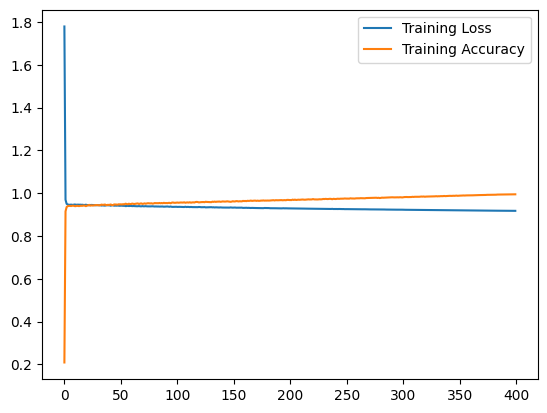

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')

plt.plot(history.history['val_loss'], label='Test Loss')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')

plt.title('Training loss and accuracy of the CNN-svm model on MNIST')
plt.xlabel('Epoch')
plt.ylabel('Loss and accuracy')
plt.legend()
plt.savefig('MNIST-svm.png')
plt.show()

In [ ]:
def add_noise(epoch):
    sd = max(1.0 - epoch/400, 0)
    return sd

In [ ]:
# Evaluate the model on the test data
score = l2svm_model.evaluate(x_test_pca, y_test_svm, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9207965731620789
Test accuracy: 0.9832000136375427


### linear activation

In [ ]:
l2svm_model = tf.keras.Sequential([
    GaussianNoise(1.0, input_shape=(70,)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(10, activation='linear', kernel_regularizer=l2(l2=0.003), name='svm')
])

In [ ]:
optimizer = SGD(lr=0.1, momentum=0.9, nesterov=True)
l2svm_model.compile(loss='squared_hinge', optimizer=optimizer, metrics=['accuracy'])

learning rate decay from 0.1 to 0.0

In [ ]:
def lr_schedule(epoch):
    lr = 0.1 - (0.1 / 400) * (epoch)
    return lr

learning_rate = LearningRateScheduler(lr_schedule)

Noise of standard deviation of 1.0 (linearly decayed to 0) is added

In [ ]:
from keras.callbacks import Callback
class GaussianNoiseDecay(Callback):
    def __init__(self, max_epochs, stddev_start=1.0, stddev_end=0.0):
        super(GaussianNoiseDecay, self).__init__()
        self.max_epochs = max_epochs
        self.stddev_start = stddev_start
        self.stddev_end = stddev_end

    def on_epoch_begin(self, epoch, logs=None):
        progress = epoch / self.max_epochs
        stddev = (1 - progress) * self.stddev_start + progress * self.stddev_end
        self.model.layers[0].stddev = stddev
        print(f"stddev: {stddev:.4f}")

In [ ]:
noise_callback = GaussianNoiseDecay(400)

In [ ]:
history = l2svm_model.fit(x_train_pca, y_train_svm,
                epochs=400, 
                batch_size=200,
                validation_data=(x_test_pca, y_test_svm), 
                verbose=1,
                callbacks=[learning_rate, noise_callback])


stddev: 1.0000
Epoch 1/400
300/300 [==============================] - 5s 14ms/step - loss: 0.1938 - accuracy: 0.7408 - val_loss: 0.0782 - val_accuracy: 0.9269 - lr: 0.1000
stddev: 0.9975
Epoch 2/400
300/300 [==============================] - 4s 13ms/step - loss: 0.1365 - accuracy: 0.8029 - val_loss: 0.0627 - val_accuracy: 0.9370 - lr: 0.0997
stddev: 0.9950
Epoch 3/400
300/300 [==============================] - 5s 17ms/step - loss: 0.1249 - accuracy: 0.8194 - val_loss: 0.0541 - val_accuracy: 0.9453 - lr: 0.0995
stddev: 0.9925
Epoch 4/400
300/300 [==============================] - 4s 13ms/step - loss: 0.1193 - accuracy: 0.8272 - val_loss: 0.0493 - val_accuracy: 0.9468 - lr: 0.0993
stddev: 0.9900
Epoch 5/400
300/300 [==============================] - 4s 13ms/step - loss: 0.1154 - accuracy: 0.8318 - val_loss: 0.0460 - val_accuracy: 0.9497 - lr: 0.0990
stddev: 0.9875
Epoch 6/400
300/300 [==============================] - 5s 17ms/step - loss: 0.1111 - accuracy: 0.8392 - val_loss: 0.0414 - va

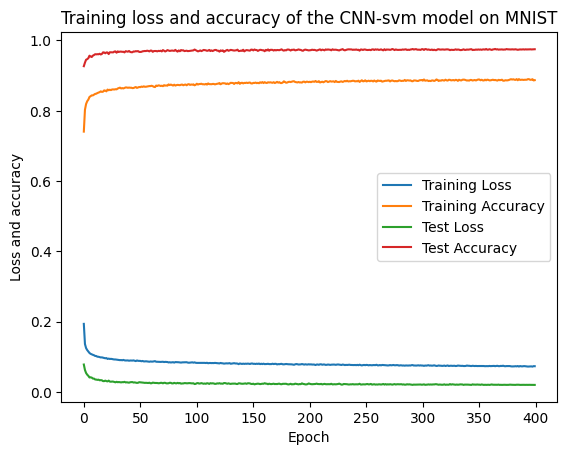

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')

plt.plot(history.history['val_loss'], label='Test Loss')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')

plt.title('Training loss and accuracy of the CNN-svm model on MNIST')
plt.xlabel('Epoch')
plt.ylabel('Loss and accuracy')
plt.legend()
plt.savefig('MNIST-svm-linear.png')
plt.show()

In [ ]:
# Evaluate the model on the test data
score = l2svm_model.evaluate(x_test_pca, y_test_svm, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.02021602727472782
Test accuracy: 0.9750999808311462


### Linear Using Squared-Hinge

#### fine tune

Cross validation

In [ ]:
!pip install --quiet optuna

In [ ]:
import optuna
from sklearn.model_selection import KFold

In [ ]:
def objective(trial):
    wd = trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
    k = 5
    kf = KFold(n_splits=k)

    # Train and evaluate model on each fold
    val_accs = []
    for train_idx, val_idx in kf.split(x_train_pca):
      # Split data into train and validation sets
      x_train_fold, y_train_fold = x_train_pca[train_idx], y_train_svm[train_idx]
      x_val_fold, y_val_fold = x_train_pca[val_idx], y_train_svm[val_idx]
   
      # Build the model
      l2svm_model = tf.keras.Sequential([
          GaussianNoise(1.0, input_shape=(70,)),
          tf.keras.layers.Dense(512, activation='relu'),
          tf.keras.layers.Dense(512, activation='relu'), 
          tf.keras.layers.Dense(10, activation='linear', kernel_regularizer=l2(l2=wd), name='svm')
      ])
      
      # Compile the model
      print("the Weight decay constant is ")
      print(wd)

      optimizer = SGD(lr=0.1, momentum=0.9, nesterov=True)
      l2svm_model.compile(loss='squared_hinge', optimizer=optimizer, metrics=['accuracy'])

      def lr_schedule(epoch):
          lr = 0.1 - (0.1 / 20) * (epoch)
          return lr

      learning_rate = LearningRateScheduler(lr_schedule)
      noise_callback = GaussianNoiseDecay(20)

      # Fit the model      
      history = l2svm_model.fit(x_train_fold, y_train_fold,
                epochs=20, 
                batch_size=200,
                validation_data=(x_val_fold, y_val_fold), 
                verbose=1,
                callbacks=[learning_rate, noise_callback])


      # Evaluate model on current fold
      _, val_acc = l2svm_model.evaluate(x_val_fold, y_val_fold, verbose=1)
      val_accs.append(val_acc)

    # Return average validation accuracy across all folds
    return sum(val_accs) / len(val_accs)




In [ ]:
# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
print('Best hyperparameters: ', study.best_params)
print('Best test set accuracy: ', study.best_value)

[I 2023-04-26 01:10:53,535] A new study created in memory with name: no-name-995c266e-206f-421d-a3bb-09cd140f18ee
<ipython-input-11-44c11e339df7>:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  wd = trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)


the Weight decay constant is 
0.00028863265171819133
stddev: 1.0000
Epoch 1/20
240/240 [==============================] - 10s 39ms/step - loss: 0.1747 - accuracy: 0.7373 - val_loss: 0.0674 - val_accuracy: 0.9272 - lr: 0.1000
stddev: 0.9500
Epoch 2/20
240/240 [==============================] - 6s 27ms/step - loss: 0.1274 - accuracy: 0.8111 - val_loss: 0.0537 - val_accuracy: 0.9411 - lr: 0.0950
stddev: 0.9000
Epoch 3/20
240/240 [==============================] - 7s 29ms/step - loss: 0.1176 - accuracy: 0.8258 - val_loss: 0.0467 - val_accuracy: 0.9503 - lr: 0.0900
stddev: 0.8500
Epoch 4/20
240/240 [==============================] - 3s 14ms/step - loss: 0.1125 - accuracy: 0.8354 - val_loss: 0.0440 - val_accuracy: 0.9502 - lr: 0.0850
stddev: 0.8000
Epoch 5/20
240/240 [==============================] - 3s 13ms/step - loss: 0.1077 - accuracy: 0.8418 - val_loss: 0.0406 - val_accuracy: 0.9538 - lr: 0.0800
stddev: 0.7500
Epoch 6/20
240/240 [==============================] - 4s 15ms/step - loss: 0

[I 2023-04-26 01:18:40,923] Trial 0 finished with value: 0.9609666705131531 and parameters: {'weight_decay': 0.00028863265171819133}. Best is trial 0 with value: 0.9609666705131531.


the Weight decay constant is 
0.020806477567665422
stddev: 1.0000
Epoch 1/20
240/240 [==============================] - 4s 14ms/step - loss: 0.2395 - accuracy: 0.7004 - val_loss: 0.1228 - val_accuracy: 0.8779 - lr: 0.1000
stddev: 0.9500
Epoch 2/20
240/240 [==============================] - 4s 15ms/step - loss: 0.1697 - accuracy: 0.7567 - val_loss: 0.0966 - val_accuracy: 0.9031 - lr: 0.0950
stddev: 0.9000
Epoch 3/20
240/240 [==============================] - 4s 17ms/step - loss: 0.1561 - accuracy: 0.7737 - val_loss: 0.0860 - val_accuracy: 0.9147 - lr: 0.0900
stddev: 0.8500
Epoch 4/20
240/240 [==============================] - 5s 19ms/step - loss: 0.1474 - accuracy: 0.7884 - val_loss: 0.0800 - val_accuracy: 0.9153 - lr: 0.0850
stddev: 0.8000
Epoch 5/20
240/240 [==============================] - 3s 13ms/step - loss: 0.1415 - accuracy: 0.7975 - val_loss: 0.0720 - val_accuracy: 0.9227 - lr: 0.0800
stddev: 0.7500
Epoch 6/20
240/240 [==============================] - 5s 19ms/step - loss: 0.13

[I 2023-04-26 01:25:10,125] Trial 1 finished with value: 0.9456000089645386 and parameters: {'weight_decay': 0.020806477567665422}. Best is trial 0 with value: 0.9609666705131531.


the Weight decay constant is 
0.0011968011286711078
stddev: 1.0000
Epoch 1/20
240/240 [==============================] - 5s 20ms/step - loss: 0.1904 - accuracy: 0.7370 - val_loss: 0.0794 - val_accuracy: 0.9186 - lr: 0.1000
stddev: 0.9500
Epoch 2/20
240/240 [==============================] - 3s 14ms/step - loss: 0.1356 - accuracy: 0.8070 - val_loss: 0.0615 - val_accuracy: 0.9332 - lr: 0.0950
stddev: 0.9000
Epoch 3/20
240/240 [==============================] - 3s 13ms/step - loss: 0.1231 - accuracy: 0.8240 - val_loss: 0.0531 - val_accuracy: 0.9416 - lr: 0.0900
stddev: 0.8500
Epoch 4/20
240/240 [==============================] - 4s 16ms/step - loss: 0.1173 - accuracy: 0.8309 - val_loss: 0.0504 - val_accuracy: 0.9463 - lr: 0.0850
stddev: 0.8000
Epoch 5/20
240/240 [==============================] - 4s 17ms/step - loss: 0.1142 - accuracy: 0.8334 - val_loss: 0.0463 - val_accuracy: 0.9496 - lr: 0.0800
stddev: 0.7500
Epoch 6/20
240/240 [==============================] - 3s 13ms/step - loss: 0.1

[I 2023-04-26 01:32:03,964] Trial 2 finished with value: 0.9571666598320008 and parameters: {'weight_decay': 0.0011968011286711078}. Best is trial 0 with value: 0.9609666705131531.


the Weight decay constant is 
1.573880200076061e-05
stddev: 1.0000
Epoch 1/20
240/240 [==============================] - 4s 15ms/step - loss: 0.1700 - accuracy: 0.7416 - val_loss: 0.0602 - val_accuracy: 0.9291 - lr: 0.1000
stddev: 0.9500
Epoch 2/20
240/240 [==============================] - 5s 20ms/step - loss: 0.1215 - accuracy: 0.8117 - val_loss: 0.0463 - val_accuracy: 0.9421 - lr: 0.0950
stddev: 0.9000
Epoch 3/20
240/240 [==============================] - 4s 18ms/step - loss: 0.1122 - accuracy: 0.8270 - val_loss: 0.0411 - val_accuracy: 0.9465 - lr: 0.0900
stddev: 0.8500
Epoch 4/20
240/240 [==============================] - 3s 14ms/step - loss: 0.1076 - accuracy: 0.8332 - val_loss: 0.0361 - val_accuracy: 0.9524 - lr: 0.0850
stddev: 0.8000
Epoch 5/20
240/240 [==============================] - 5s 20ms/step - loss: 0.1030 - accuracy: 0.8419 - val_loss: 0.0357 - val_accuracy: 0.9527 - lr: 0.0800
stddev: 0.7500
Epoch 6/20
240/240 [==============================] - 3s 14ms/step - loss: 0.0

[I 2023-04-26 01:38:46,186] Trial 3 finished with value: 0.9635666608810425 and parameters: {'weight_decay': 1.573880200076061e-05}. Best is trial 3 with value: 0.9635666608810425.


the Weight decay constant is 
0.00015753460346177453
stddev: 1.0000
Epoch 1/20
240/240 [==============================] - 5s 19ms/step - loss: 0.1753 - accuracy: 0.7326 - val_loss: 0.0637 - val_accuracy: 0.9253 - lr: 0.1000
stddev: 0.9500
Epoch 2/20
240/240 [==============================] - 3s 13ms/step - loss: 0.1253 - accuracy: 0.8098 - val_loss: 0.0499 - val_accuracy: 0.9412 - lr: 0.0950
stddev: 0.9000
Epoch 3/20
240/240 [==============================] - 3s 13ms/step - loss: 0.1155 - accuracy: 0.8265 - val_loss: 0.0435 - val_accuracy: 0.9479 - lr: 0.0900
stddev: 0.8500
Epoch 4/20
240/240 [==============================] - 4s 18ms/step - loss: 0.1101 - accuracy: 0.8355 - val_loss: 0.0406 - val_accuracy: 0.9501 - lr: 0.0850
stddev: 0.8000
Epoch 5/20
240/240 [==============================] - 4s 15ms/step - loss: 0.1067 - accuracy: 0.8397 - val_loss: 0.0397 - val_accuracy: 0.9501 - lr: 0.0800
stddev: 0.7500
Epoch 6/20
240/240 [==============================] - 3s 14ms/step - loss: 0.

[I 2023-04-26 01:45:30,934] Trial 4 finished with value: 0.9623666524887085 and parameters: {'weight_decay': 0.00015753460346177453}. Best is trial 3 with value: 0.9635666608810425.


the Weight decay constant is 
0.042357903602386754
stddev: 1.0000
Epoch 1/20
240/240 [==============================] - 4s 16ms/step - loss: 0.2646 - accuracy: 0.6795 - val_loss: 0.1346 - val_accuracy: 0.8732 - lr: 0.1000
stddev: 0.9500
Epoch 2/20
240/240 [==============================] - 4s 18ms/step - loss: 0.1820 - accuracy: 0.7374 - val_loss: 0.1089 - val_accuracy: 0.8847 - lr: 0.0950
stddev: 0.9000
Epoch 3/20
240/240 [==============================] - 3s 14ms/step - loss: 0.1677 - accuracy: 0.7559 - val_loss: 0.1003 - val_accuracy: 0.9016 - lr: 0.0900
stddev: 0.8500
Epoch 4/20
240/240 [==============================] - 3s 14ms/step - loss: 0.1587 - accuracy: 0.7707 - val_loss: 0.0870 - val_accuracy: 0.9127 - lr: 0.0850
stddev: 0.8000
Epoch 5/20
240/240 [==============================] - 4s 17ms/step - loss: 0.1527 - accuracy: 0.7791 - val_loss: 0.0814 - val_accuracy: 0.9187 - lr: 0.0800
stddev: 0.7500
Epoch 6/20
240/240 [==============================] - 4s 16ms/step - loss: 0.14

[I 2023-04-26 01:52:15,780] Trial 5 finished with value: 0.93878333568573 and parameters: {'weight_decay': 0.042357903602386754}. Best is trial 3 with value: 0.9635666608810425.


the Weight decay constant is 
0.002467464023791669
stddev: 1.0000
Epoch 1/20
240/240 [==============================] - 4s 14ms/step - loss: 0.1984 - accuracy: 0.7335 - val_loss: 0.0853 - val_accuracy: 0.9178 - lr: 0.1000
stddev: 0.9500
Epoch 2/20
240/240 [==============================] - 3s 14ms/step - loss: 0.1416 - accuracy: 0.7980 - val_loss: 0.0677 - val_accuracy: 0.9327 - lr: 0.0950
stddev: 0.9000
Epoch 3/20
240/240 [==============================] - 5s 20ms/step - loss: 0.1293 - accuracy: 0.8137 - val_loss: 0.0590 - val_accuracy: 0.9380 - lr: 0.0900
stddev: 0.8500
Epoch 4/20
240/240 [==============================] - 4s 15ms/step - loss: 0.1234 - accuracy: 0.8211 - val_loss: 0.0557 - val_accuracy: 0.9390 - lr: 0.0850
stddev: 0.8000
Epoch 5/20
240/240 [==============================] - 3s 13ms/step - loss: 0.1191 - accuracy: 0.8299 - val_loss: 0.0513 - val_accuracy: 0.9459 - lr: 0.0800
stddev: 0.7500
Epoch 6/20
240/240 [==============================] - 3s 14ms/step - loss: 0.11

[I 2023-04-26 01:59:03,500] Trial 6 finished with value: 0.9554500102996826 and parameters: {'weight_decay': 0.002467464023791669}. Best is trial 3 with value: 0.9635666608810425.


the Weight decay constant is 
4.2229557102236194e-05
stddev: 1.0000
Epoch 1/20
240/240 [==============================] - 5s 18ms/step - loss: 0.1671 - accuracy: 0.7394 - val_loss: 0.0631 - val_accuracy: 0.9271 - lr: 0.1000
stddev: 0.9500
Epoch 2/20
240/240 [==============================] - 3s 14ms/step - loss: 0.1227 - accuracy: 0.8139 - val_loss: 0.0472 - val_accuracy: 0.9431 - lr: 0.0950
stddev: 0.9000
Epoch 3/20
240/240 [==============================] - 3s 14ms/step - loss: 0.1132 - accuracy: 0.8281 - val_loss: 0.0425 - val_accuracy: 0.9463 - lr: 0.0900
stddev: 0.8500
Epoch 4/20
240/240 [==============================] - 5s 19ms/step - loss: 0.1066 - accuracy: 0.8385 - val_loss: 0.0382 - val_accuracy: 0.9513 - lr: 0.0850
stddev: 0.8000
Epoch 5/20
240/240 [==============================] - 3s 14ms/step - loss: 0.1043 - accuracy: 0.8394 - val_loss: 0.0369 - val_accuracy: 0.9538 - lr: 0.0800
stddev: 0.7500
Epoch 6/20
240/240 [==============================] - 3s 14ms/step - loss: 0.

[I 2023-04-26 02:05:46,005] Trial 7 finished with value: 0.9635833382606507 and parameters: {'weight_decay': 4.2229557102236194e-05}. Best is trial 7 with value: 0.9635833382606507.


the Weight decay constant is 
1.3302191802445002e-05
stddev: 1.0000
Epoch 1/20
240/240 [==============================] - 4s 15ms/step - loss: 0.1680 - accuracy: 0.7402 - val_loss: 0.0623 - val_accuracy: 0.9267 - lr: 0.1000
stddev: 0.9500
Epoch 2/20
240/240 [==============================] - 3s 14ms/step - loss: 0.1217 - accuracy: 0.8112 - val_loss: 0.0471 - val_accuracy: 0.9421 - lr: 0.0950
stddev: 0.9000
Epoch 3/20
240/240 [==============================] - 5s 20ms/step - loss: 0.1114 - accuracy: 0.8274 - val_loss: 0.0412 - val_accuracy: 0.9477 - lr: 0.0900
stddev: 0.8500
Epoch 4/20
240/240 [==============================] - 3s 14ms/step - loss: 0.1070 - accuracy: 0.8367 - val_loss: 0.0384 - val_accuracy: 0.9507 - lr: 0.0850
stddev: 0.8000
Epoch 5/20
240/240 [==============================] - 3s 14ms/step - loss: 0.1036 - accuracy: 0.8416 - val_loss: 0.0364 - val_accuracy: 0.9525 - lr: 0.0800
stddev: 0.7500
Epoch 6/20
240/240 [==============================] - 4s 15ms/step - loss: 0.

[I 2023-04-26 02:12:29,199] Trial 8 finished with value: 0.9633999943733216 and parameters: {'weight_decay': 1.3302191802445002e-05}. Best is trial 7 with value: 0.9635833382606507.


the Weight decay constant is 
0.0006916993813007205
stddev: 1.0000
Epoch 1/20
240/240 [==============================] - 4s 15ms/step - loss: 0.1794 - accuracy: 0.7391 - val_loss: 0.0742 - val_accuracy: 0.9237 - lr: 0.1000
stddev: 0.9500
Epoch 2/20
240/240 [==============================] - 5s 20ms/step - loss: 0.1317 - accuracy: 0.8101 - val_loss: 0.0584 - val_accuracy: 0.9377 - lr: 0.0950
stddev: 0.9000
Epoch 3/20
240/240 [==============================] - 3s 14ms/step - loss: 0.1207 - accuracy: 0.8252 - val_loss: 0.0526 - val_accuracy: 0.9417 - lr: 0.0900
stddev: 0.8500
Epoch 4/20
240/240 [==============================] - 3s 14ms/step - loss: 0.1146 - accuracy: 0.8331 - val_loss: 0.0473 - val_accuracy: 0.9477 - lr: 0.0850
stddev: 0.8000
Epoch 5/20
240/240 [==============================] - 4s 15ms/step - loss: 0.1112 - accuracy: 0.8375 - val_loss: 0.0444 - val_accuracy: 0.9503 - lr: 0.0800
stddev: 0.7500
Epoch 6/20
240/240 [==============================] - 4s 19ms/step - loss: 0.1

[I 2023-04-26 02:19:13,655] Trial 9 finished with value: 0.9595166683197022 and parameters: {'weight_decay': 0.0006916993813007205}. Best is trial 7 with value: 0.9635833382606507.


Best hyperparameters:  {'weight_decay': 4.2229557102236194e-05}
Best test set accuracy:  0.9635833382606507


#### implementation

In [ ]:
L2 = 0.055
def l2_svm_loss(y_true, y_pred):
    # Replace 0 with -1 in y_true
    y_true = tf.where(tf.equal(y_true, 0), -tf.ones_like(y_true), y_true)
    
    # Compute hinge loss
    hinge_loss = L2 * tf.reduce_mean(tf.square(tf.maximum(0., 1. - y_true * y_pred)))
    # Compute L2 regularization term
    l2_reg_term = 0.5 * tf.reduce_sum(tf.matmul(tf.transpose(l2svm_model.get_layer('svm').kernel), l2svm_model.get_layer('svm').kernel))
    
    # Add hinge loss and L2 regularization term
    return hinge_loss + l2_reg_term

In [ ]:
l2svm_model = tf.keras.Sequential([
    GaussianNoise(1.0, input_shape=(70,)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(10, activation='linear', kernel_regularizer=l2(l2=4.2229557102236194e-05), name='svm')
])

In [ ]:
optimizer = SGD(lr=0.1, momentum=0.9, nesterov=True)
l2svm_model.compile(loss='squared_hinge', optimizer=optimizer, metrics=['accuracy'])

learning rate decay from 0.1 to 0.0

In [ ]:
def lr_schedule(epoch):
    lr = 0.1 - (0.1 / 400) * (epoch)
    return lr

learning_rate = LearningRateScheduler(lr_schedule)

Noise of standard deviation of 1.0 (linearly decayed to 0) is added

In [ ]:
from keras.callbacks import Callback
class GaussianNoiseDecay(Callback):
    def __init__(self, max_epochs, stddev_start=1.0, stddev_end=0.0):
        super(GaussianNoiseDecay, self).__init__()
        self.max_epochs = max_epochs
        self.stddev_start = stddev_start
        self.stddev_end = stddev_end

    def on_epoch_begin(self, epoch, logs=None):
        progress = epoch / self.max_epochs
        stddev = (1 - progress) * self.stddev_start + progress * self.stddev_end
        self.model.layers[0].stddev = stddev
        print(f"stddev: {stddev:.4f}")

In [ ]:
noise_callback = GaussianNoiseDecay(400)

In [ ]:
history = l2svm_model.fit(x_train_pca, y_train_svm,
                epochs=400, 
                batch_size=200,
                validation_data=(x_test_pca, y_test_svm), 
                verbose=1,
                callbacks=[learning_rate, noise_callback])


stddev: 1.0000
Epoch 1/400
300/300 [==============================] - 6s 18ms/step - loss: 0.1608 - accuracy: 0.7539 - val_loss: 0.0545 - val_accuracy: 0.9373 - lr: 0.1000
stddev: 0.9975
Epoch 2/400
300/300 [==============================] - 4s 13ms/step - loss: 0.1176 - accuracy: 0.8204 - val_loss: 0.0412 - val_accuracy: 0.9517 - lr: 0.0997
stddev: 0.9950
Epoch 3/400
300/300 [==============================] - 4s 13ms/step - loss: 0.1096 - accuracy: 0.8313 - val_loss: 0.0362 - val_accuracy: 0.9556 - lr: 0.0995
stddev: 0.9925
Epoch 4/400
300/300 [==============================] - 5s 18ms/step - loss: 0.1043 - accuracy: 0.8417 - val_loss: 0.0338 - val_accuracy: 0.9561 - lr: 0.0993
stddev: 0.9900
Epoch 5/400
300/300 [==============================] - 4s 13ms/step - loss: 0.1001 - accuracy: 0.8451 - val_loss: 0.0318 - val_accuracy: 0.9592 - lr: 0.0990
stddev: 0.9875
Epoch 6/400
300/300 [==============================] - 4s 13ms/step - loss: 0.0980 - accuracy: 0.8484 - val_loss: 0.0306 - va

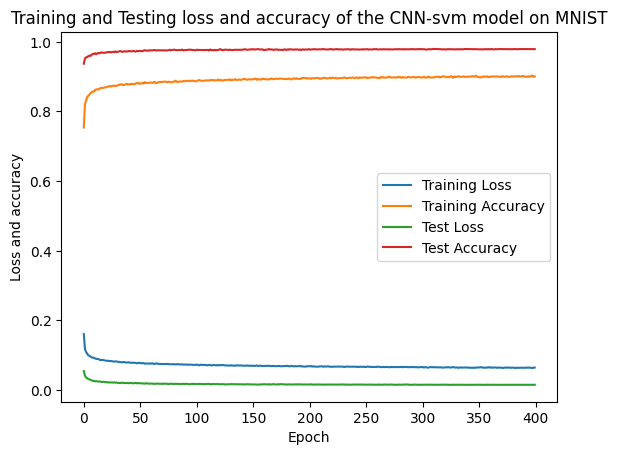

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')

plt.plot(history.history['val_loss'], label='Test Loss')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')

plt.title('Training and Testing loss and accuracy of the CNN-svm model on MNIST')
plt.xlabel('Epoch')
plt.ylabel('Loss and accuracy')
plt.legend()
plt.savefig('MNIST-svm-linear.png')
plt.show()

In [ ]:
# Evaluate the model on the test data
score = l2svm_model.evaluate(x_test_pca, y_test_svm, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.015156692825257778
Test accuracy: 0.9790999889373779


#### Prediction

In [ ]:
# Make predictions using the loaded model
predictions_mnist_svm = l2svm_model.predict(x_test_pca)

313/313 [==============================] - 2s 4ms/step


In [ ]:
y_pred_mnist_svm = np.argmax(predictions_mnist_svm, axis=-1)

In [ ]:
y_pred_mnist_svm

array([7, 2, 1, ..., 4, 5, 6])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test_svm, axis=-1), y_pred_mnist_svm))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.96      1.00      0.98      1135
           2       0.99      0.98      0.98      1032
           3       0.99      0.98      0.98      1010
           4       0.99      0.97      0.98       982
           5       0.99      0.98      0.98       892
           6       0.98      0.99      0.98       958
           7       0.97      0.96      0.96      1028
           8       0.99      0.97      0.98       974
           9       0.96      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



## linear activation DIY loss

### Build model

In [ ]:
l2svm_model = tf.keras.Sequential([
    GaussianNoise(1.0, input_shape=(70,)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(10, activation='linear', name='svm')
])

In [ ]:
L2 = 0.055
def l2_svm_loss(y_true, y_pred):
    # Replace 0 with -1 in y_true
    y_true = tf.where(tf.equal(y_true, 0), -tf.ones_like(y_true), y_true)
    
    # Compute hinge loss
    hinge_loss = L2 * tf.reduce_mean(tf.square(tf.maximum(0., 1. - y_true * y_pred)))
    # Compute L2 regularization term
    l2_reg_term = 0.5 * tf.reduce_sum(tf.matmul(tf.transpose(l2svm_model.get_layer('svm').kernel), l2svm_model.get_layer('svm').kernel))
    
    # Add hinge loss and L2 regularization term
    return hinge_loss + l2_reg_term

In [ ]:
optimizer = SGD(lr=0.1, momentum=0.9, nesterov=True)
l2svm_model.compile(loss=l2_svm_loss, optimizer=optimizer, metrics=['accuracy'])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


learning rate decay from 0.1 to 0.0

In [ ]:
def lr_schedule(epoch):
    lr = 0.1 - (0.1 / 400) * (epoch)
    return lr

learning_rate = LearningRateScheduler(lr_schedule)

Noise of standard deviation of 1.0 (linearly decayed to 0) is added

In [ ]:
from keras.callbacks import Callback
class GaussianNoiseDecay(Callback):
    def __init__(self, max_epochs, stddev_start=1.0, stddev_end=0.0):
        super(GaussianNoiseDecay, self).__init__()
        self.max_epochs = max_epochs
        self.stddev_start = stddev_start
        self.stddev_end = stddev_end

    def on_epoch_begin(self, epoch, logs=None):
        progress = epoch / self.max_epochs
        stddev = (1 - progress) * self.stddev_start + progress * self.stddev_end
        self.model.layers[0].stddev = stddev
        print(f"stddev: {stddev:.4f}")

In [ ]:
noise_callback = GaussianNoiseDecay(400)

In [ ]:
history_svm_mnist = l2svm_model.fit(x_train_pca, y_train_svm,
                epochs=400, 
                batch_size=200,
                validation_data=(x_test_pca, y_test_svm), 
                verbose=1,
                callbacks=[learning_rate, noise_callback])


stddev: 1.0000
Epoch 1/400
300/300 [==============================] - 2s 4ms/step - loss: 0.0820 - accuracy: 0.5761 - val_loss: 0.0079 - val_accuracy: 0.8501 - lr: 0.1000
stddev: 0.9975
Epoch 2/400
300/300 [==============================] - 1s 3ms/step - loss: 0.0106 - accuracy: 0.7125 - val_loss: 0.0061 - val_accuracy: 0.8816 - lr: 0.0997
stddev: 0.9950
Epoch 3/400
300/300 [==============================] - 1s 3ms/step - loss: 0.0096 - accuracy: 0.7413 - val_loss: 0.0053 - val_accuracy: 0.8951 - lr: 0.0995
stddev: 0.9925
Epoch 4/400
300/300 [==============================] - 1s 3ms/step - loss: 0.0091 - accuracy: 0.7575 - val_loss: 0.0047 - val_accuracy: 0.9067 - lr: 0.0993
stddev: 0.9900
Epoch 5/400
300/300 [==============================] - 1s 3ms/step - loss: 0.0086 - accuracy: 0.7681 - val_loss: 0.0043 - val_accuracy: 0.9143 - lr: 0.0990
stddev: 0.9875
Epoch 6/400
300/300 [==============================] - 1s 3ms/step - loss: 0.0083 - accuracy: 0.7768 - val_loss: 0.0040 - val_accu

In [ ]:
# Evaluate the model on the test data
score = l2svm_model.evaluate(x_test_pca, y_test_svm, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.0013 - accuracy: 0.9690
Test loss: 0.0012606590753421187
Test accuracy: 0.968999981880188


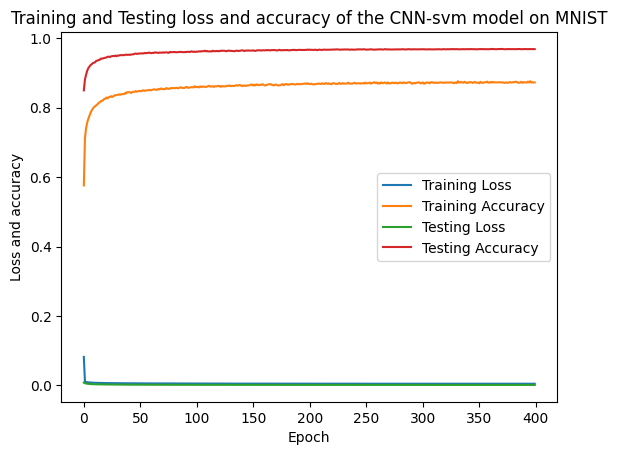

In [ ]:
plt.plot(history_svm_mnist.history['loss'], label='Training Loss')
plt.plot(history_svm_mnist.history['accuracy'], label='Training Accuracy')
plt.plot(history_svm_mnist.history['val_loss'], label='Testing Loss')
plt.plot(history_svm_mnist.history['val_accuracy'], label='Testing Accuracy')
plt.title('Training and Testing loss and accuracy of the CNN-svm model on MNIST')
plt.xlabel('Epoch')
plt.ylabel('Loss and accuracy')
plt.legend()
plt.show()

### Prediction

In [ ]:
# Make predictions using the loaded model
predictions_l2svm_mnist = l2svm_model.predict(x_test_pca)

313/313 [==============================] - 0s 1ms/step


In [ ]:
y_pred_svm_mnist = np.argmax(predictions_l2svm_mnist, axis=-1)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_sfm, y_pred_svm_mnist))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.94      1.00      0.97      1135
           2       0.99      0.96      0.97      1032
           3       0.98      0.97      0.97      1010
           4       0.98      0.95      0.96       982
           5       0.98      0.97      0.98       892
           6       0.97      0.98      0.98       958
           7       0.96      0.95      0.96      1028
           8       0.99      0.95      0.97       974
           9       0.94      0.97      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



### Cross validation

In [ ]:
def objective_svm_MNIST(trial):
    C = trial.suggest_loguniform('C', 1e-5, 1e-1)
    # wd = trial.suggest_loguniform('wd', 1e-5, 1e-1)
    k = 5
    kf = KFold(n_splits=k)
    def lr_schedule(epoch):
      lr = 0.1 - (0.1 / 400) * (epoch)
      return lr
    learning_rate = LearningRateScheduler(lr_schedule)
    def l2_svm_loss(y_true, y_pred):
        # Replace 0 with -1 in y_true
        y_true = tf.where(tf.equal(y_true, 0), -tf.ones_like(y_true), y_true)
        
        # Compute hinge loss
        hinge_loss = C * tf.reduce_mean(tf.square(tf.maximum(0., 1. - y_true * y_pred)))
        
        # Compute L2 regularization term
        l2_reg_term = 0.5 * tf.reduce_sum(tf.matmul(tf.transpose(model_cross_svm.get_layer('svm').kernel), model_cross_svm.get_layer('svm').kernel))
        
        # Add hinge loss and L2 regularization term
        return hinge_loss + l2_reg_term
        
    # Train and evaluate model on each fold
    noise_callback = GaussianNoiseDecay(400)
    val_accs = []
    for train_idx, val_idx in kf.split(x_train):
      # Split data into train and validation sets
      x_train_fold, y_train_fold = x_train_pca[train_idx], y_train_svm[train_idx]
      x_val_fold, y_val_fold = x_train_pca[val_idx], y_train_svm[val_idx]
    # Build the model
      model_cross_svm = tf.keras.Sequential([
          GaussianNoise(1.0, input_shape=(70,)),
          tf.keras.layers.Dense(512, activation='relu'),
          tf.keras.layers.Dense(512, activation='relu'), 
          tf.keras.layers.Dense(10, activation='linear', name='svm')
      ])
      
      # Compile the model
      print("the learning rate is ")
      print(learning_rate)
      print("the C constant is ")
      print(C)
      optimizer = SGD(lr=0.1, momentum=0.9, nesterov=True)
      model_cross_svm.compile(loss=l2_svm_loss, optimizer=optimizer, metrics=['accuracy'])
      
      # Fit the model
      history = model_cross_svm.fit(x_train_fold, y_train_fold, epochs=50, batch_size=200, validation_data=(x_val_fold, y_val_fold), verbose=1, callbacks=[learning_rate, noise_callback])
      # history = model_cross_svm.fit(x_train_pca, y_train_svm,
      #           epochs=400, 
      #           batch_size=200,
      #           validation_data=(x_test_pca, y_test_svm), 
      #           verbose=1,
      #           callbacks=[learning_rate, noise_callback])
      # Evaluate model on current fold
      _, val_acc = model_cross_svm.evaluate(x_val_fold, y_val_fold, verbose=1)
      val_accs.append(val_acc)

    # Return average validation accuracy across all folds
    return sum(val_accs) / len(val_accs)




In [ ]:
# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective_svm_MNIST, n_trials=10)
print('Best hyperparameters: ', study.best_params)
print('Best test set accuracy: ', study.best_value)

[I 2023-04-25 22:27:48,664] A new study created in memory with name: no-name-eb90f2a8-31c8-4f00-b0a1-7c7d29ae6ae5


the learning rate is 
the C constant is 
0.0001035715360956932
stddev: 1.0000
Epoch 1/50


<ipython-input-80-e55fbb56662f>:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e-1)


240/240 [==============================] - 1s 4ms/step - loss: 0.0797 - accuracy: 0.1101 - val_loss: 1.0834e-04 - val_accuracy: 0.1002 - lr: 0.1000
stddev: 0.9975
Epoch 2/50
240/240 [==============================] - 1s 3ms/step - loss: 1.1490e-04 - accuracy: 0.1122 - val_loss: 1.0674e-04 - val_accuracy: 0.1067 - lr: 0.0997
stddev: 0.9950
Epoch 3/50
240/240 [==============================] - 1s 3ms/step - loss: 1.1263e-04 - accuracy: 0.1142 - val_loss: 1.0514e-04 - val_accuracy: 0.1129 - lr: 0.0995
stddev: 0.9925
Epoch 4/50
240/240 [==============================] - 1s 3ms/step - loss: 1.1086e-04 - accuracy: 0.1194 - val_loss: 1.0463e-04 - val_accuracy: 0.1215 - lr: 0.0993
stddev: 0.9900
Epoch 5/50
240/240 [==============================] - 1s 3ms/step - loss: 1.0933e-04 - accuracy: 0.1256 - val_loss: 1.0334e-04 - val_accuracy: 0.1274 - lr: 0.0990
stddev: 0.9875
Epoch 6/50
240/240 [==============================] - 1s 3ms/step - loss: 1.0805e-04 - accuracy: 0.1284 - val_loss: 1.0147e-0

[I 2023-04-25 22:30:48,602] Trial 0 finished with value: 0.5092833280563355 and parameters: {'C': 0.0001035715360956932}. Best is trial 0 with value: 0.5092833280563355.


the learning rate is 
the C constant is 
2.110320645872033e-05
stddev: 1.0000
Epoch 1/50
240/240 [==============================] - 1s 3ms/step - loss: 0.0731 - accuracy: 0.1348 - val_loss: 2.2068e-05 - val_accuracy: 0.1497 - lr: 0.1000
stddev: 0.9975
Epoch 2/50
240/240 [==============================] - 1s 3ms/step - loss: 2.4251e-05 - accuracy: 0.1348 - val_loss: 2.2501e-05 - val_accuracy: 0.1510 - lr: 0.0997
stddev: 0.9950
Epoch 3/50
240/240 [==============================] - 1s 3ms/step - loss: 2.4088e-05 - accuracy: 0.1333 - val_loss: 2.2522e-05 - val_accuracy: 0.1523 - lr: 0.0995
stddev: 0.9925
Epoch 4/50
240/240 [==============================] - 1s 3ms/step - loss: 2.3949e-05 - accuracy: 0.1354 - val_loss: 2.1358e-05 - val_accuracy: 0.1528 - lr: 0.0993
stddev: 0.9900
Epoch 5/50
240/240 [==============================] - 1s 3ms/step - loss: 2.3749e-05 - accuracy: 0.1357 - val_loss: 2.1271e-05 - val_accuracy: 0.1540 - lr: 0.0990
stddev: 0.9875
Epoch 6/50
240/240 [================

[I 2023-04-25 22:34:02,364] Trial 1 finished with value: 0.18414999842643737 and parameters: {'C': 2.110320645872033e-05}. Best is trial 0 with value: 0.5092833280563355.


the learning rate is 
the C constant is 
0.015216079671946162
stddev: 1.0000
Epoch 1/50
240/240 [==============================] - 1s 3ms/step - loss: 0.0840 - accuracy: 0.3634 - val_loss: 0.0058 - val_accuracy: 0.7258 - lr: 0.1000
stddev: 0.9975
Epoch 2/50
240/240 [==============================] - 1s 3ms/step - loss: 0.0053 - accuracy: 0.5850 - val_loss: 0.0034 - val_accuracy: 0.7953 - lr: 0.0997
stddev: 0.9950
Epoch 3/50
240/240 [==============================] - 1s 3ms/step - loss: 0.0039 - accuracy: 0.6389 - val_loss: 0.0027 - val_accuracy: 0.8237 - lr: 0.0995
stddev: 0.9925
Epoch 4/50
240/240 [==============================] - 1s 3ms/step - loss: 0.0035 - accuracy: 0.6702 - val_loss: 0.0023 - val_accuracy: 0.8427 - lr: 0.0993
stddev: 0.9900
Epoch 5/50
240/240 [==============================] - 1s 3ms/step - loss: 0.0032 - accuracy: 0.6843 - val_loss: 0.0021 - val_accuracy: 0.8509 - lr: 0.0990
stddev: 0.9875
Epoch 6/50
240/240 [==============================] - 1s 3ms/step - loss:

[I 2023-04-25 22:37:10,724] Trial 2 finished with value: 0.9265833139419556 and parameters: {'C': 0.015216079671946162}. Best is trial 2 with value: 0.9265833139419556.


the learning rate is 
the C constant is 
0.026977236987426764
stddev: 1.0000
Epoch 1/50
240/240 [==============================] - 1s 4ms/step - loss: 0.0928 - accuracy: 0.4528 - val_loss: 0.0066 - val_accuracy: 0.7792 - lr: 0.1000
stddev: 0.9975
Epoch 2/50
240/240 [==============================] - 1s 3ms/step - loss: 0.0069 - accuracy: 0.6472 - val_loss: 0.0044 - val_accuracy: 0.8246 - lr: 0.0997
stddev: 0.9950
Epoch 3/50
240/240 [==============================] - 1s 3ms/step - loss: 0.0058 - accuracy: 0.6861 - val_loss: 0.0037 - val_accuracy: 0.8481 - lr: 0.0995
stddev: 0.9925
Epoch 4/50
240/240 [==============================] - 1s 3ms/step - loss: 0.0053 - accuracy: 0.7073 - val_loss: 0.0033 - val_accuracy: 0.8645 - lr: 0.0993
stddev: 0.9900
Epoch 5/50
240/240 [==============================] - 1s 3ms/step - loss: 0.0050 - accuracy: 0.7199 - val_loss: 0.0031 - val_accuracy: 0.8740 - lr: 0.0990
stddev: 0.9875
Epoch 6/50
240/240 [==============================] - 1s 3ms/step - loss:

[I 2023-04-25 22:40:13,082] Trial 3 finished with value: 0.9391333341598511 and parameters: {'C': 0.026977236987426764}. Best is trial 3 with value: 0.9391333341598511.


the learning rate is 
the C constant is 
0.00366893318382249
stddev: 1.0000
Epoch 1/50
240/240 [==============================] - 1s 4ms/step - loss: 0.0740 - accuracy: 0.1683 - val_loss: 0.0028 - val_accuracy: 0.4373 - lr: 0.1000
stddev: 0.9975
Epoch 2/50
240/240 [==============================] - 1s 3ms/step - loss: 0.0027 - accuracy: 0.3494 - val_loss: 0.0022 - val_accuracy: 0.6225 - lr: 0.0997
stddev: 0.9950
Epoch 3/50
240/240 [==============================] - 1s 3ms/step - loss: 0.0021 - accuracy: 0.4581 - val_loss: 0.0017 - val_accuracy: 0.6967 - lr: 0.0995
stddev: 0.9925
Epoch 4/50
240/240 [==============================] - 1s 3ms/step - loss: 0.0018 - accuracy: 0.5215 - val_loss: 0.0014 - val_accuracy: 0.7327 - lr: 0.0993
stddev: 0.9900
Epoch 5/50
240/240 [==============================] - 1s 3ms/step - loss: 0.0015 - accuracy: 0.5577 - val_loss: 0.0012 - val_accuracy: 0.7554 - lr: 0.0990
stddev: 0.9875
Epoch 6/50
240/240 [==============================] - 1s 3ms/step - loss: 

[I 2023-04-25 22:43:16,520] Trial 4 finished with value: 0.8797500014305115 and parameters: {'C': 0.00366893318382249}. Best is trial 3 with value: 0.9391333341598511.


the learning rate is 
the C constant is 
0.0002745553470706387
stddev: 1.0000
Epoch 1/50
240/240 [==============================] - 1s 4ms/step - loss: 0.0748 - accuracy: 0.1075 - val_loss: 2.7829e-04 - val_accuracy: 0.1269 - lr: 0.1000
stddev: 0.9975
Epoch 2/50
240/240 [==============================] - 1s 3ms/step - loss: 2.8984e-04 - accuracy: 0.1260 - val_loss: 2.6974e-04 - val_accuracy: 0.1552 - lr: 0.0997
stddev: 0.9950
Epoch 3/50
240/240 [==============================] - 1s 3ms/step - loss: 2.8052e-04 - accuracy: 0.1420 - val_loss: 2.6283e-04 - val_accuracy: 0.1849 - lr: 0.0995
stddev: 0.9925
Epoch 4/50
240/240 [==============================] - 1s 3ms/step - loss: 2.7338e-04 - accuracy: 0.1569 - val_loss: 2.5632e-04 - val_accuracy: 0.2124 - lr: 0.0993
stddev: 0.9900
Epoch 5/50
240/240 [==============================] - 1s 3ms/step - loss: 2.6714e-04 - accuracy: 0.1713 - val_loss: 2.5092e-04 - val_accuracy: 0.2412 - lr: 0.0990
stddev: 0.9875
Epoch 6/50
240/240 [================

[I 2023-04-25 22:46:27,948] Trial 5 finished with value: 0.7178333282470704 and parameters: {'C': 0.0002745553470706387}. Best is trial 3 with value: 0.9391333341598511.


the learning rate is 
the C constant is 
0.004403851939158264
stddev: 1.0000
Epoch 1/50
240/240 [==============================] - 1s 3ms/step - loss: 0.0855 - accuracy: 0.1901 - val_loss: 0.0032 - val_accuracy: 0.4725 - lr: 0.1000
stddev: 0.9975
Epoch 2/50
240/240 [==============================] - 1s 3ms/step - loss: 0.0030 - accuracy: 0.3883 - val_loss: 0.0023 - val_accuracy: 0.6497 - lr: 0.0997
stddev: 0.9950
Epoch 3/50
240/240 [==============================] - 1s 3ms/step - loss: 0.0023 - accuracy: 0.4975 - val_loss: 0.0018 - val_accuracy: 0.7183 - lr: 0.0995
stddev: 0.9925
Epoch 4/50
240/240 [==============================] - 1s 3ms/step - loss: 0.0019 - accuracy: 0.5445 - val_loss: 0.0015 - val_accuracy: 0.7546 - lr: 0.0993
stddev: 0.9900
Epoch 5/50
240/240 [==============================] - 1s 3ms/step - loss: 0.0016 - accuracy: 0.5825 - val_loss: 0.0012 - val_accuracy: 0.7766 - lr: 0.0990
stddev: 0.9875
Epoch 6/50
240/240 [==============================] - 1s 3ms/step - loss:

[I 2023-04-25 22:49:35,652] Trial 6 finished with value: 0.8902000188827515 and parameters: {'C': 0.004403851939158264}. Best is trial 3 with value: 0.9391333341598511.


the learning rate is 
the C constant is 
0.018239760353651213
stddev: 1.0000
Epoch 1/50
240/240 [==============================] - 1s 4ms/step - loss: 0.0862 - accuracy: 0.4033 - val_loss: 0.0060 - val_accuracy: 0.7609 - lr: 0.1000
stddev: 0.9975
Epoch 2/50
240/240 [==============================] - 1s 3ms/step - loss: 0.0056 - accuracy: 0.6155 - val_loss: 0.0036 - val_accuracy: 0.8148 - lr: 0.0997
stddev: 0.9950
Epoch 3/50
240/240 [==============================] - 1s 3ms/step - loss: 0.0044 - accuracy: 0.6623 - val_loss: 0.0029 - val_accuracy: 0.8389 - lr: 0.0995
stddev: 0.9925
Epoch 4/50
240/240 [==============================] - 1s 3ms/step - loss: 0.0039 - accuracy: 0.6856 - val_loss: 0.0025 - val_accuracy: 0.8535 - lr: 0.0993
stddev: 0.9900
Epoch 5/50
240/240 [==============================] - 1s 3ms/step - loss: 0.0037 - accuracy: 0.7028 - val_loss: 0.0023 - val_accuracy: 0.8623 - lr: 0.0990
stddev: 0.9875
Epoch 6/50
240/240 [==============================] - 1s 3ms/step - loss:

[I 2023-04-25 22:52:46,740] Trial 7 finished with value: 0.9315999984741211 and parameters: {'C': 0.018239760353651213}. Best is trial 3 with value: 0.9391333341598511.


the learning rate is 
the C constant is 
1.2244182956107761e-05
stddev: 1.0000
Epoch 1/50
240/240 [==============================] - 2s 6ms/step - loss: 0.0759 - accuracy: 0.1054 - val_loss: 1.2776e-05 - val_accuracy: 0.1111 - lr: 0.1000
stddev: 0.9975
Epoch 2/50
240/240 [==============================] - 1s 3ms/step - loss: 1.3660e-05 - accuracy: 0.1079 - val_loss: 1.2633e-05 - val_accuracy: 0.1118 - lr: 0.0997
stddev: 0.9950
Epoch 3/50
240/240 [==============================] - 1s 3ms/step - loss: 1.3611e-05 - accuracy: 0.1073 - val_loss: 1.2907e-05 - val_accuracy: 0.1127 - lr: 0.0995
stddev: 0.9925
Epoch 4/50
240/240 [==============================] - 1s 3ms/step - loss: 1.3544e-05 - accuracy: 0.1076 - val_loss: 1.2527e-05 - val_accuracy: 0.1128 - lr: 0.0993
stddev: 0.9900
Epoch 5/50
240/240 [==============================] - 1s 3ms/step - loss: 1.3509e-05 - accuracy: 0.1053 - val_loss: 1.3101e-05 - val_accuracy: 0.1131 - lr: 0.0990
stddev: 0.9875
Epoch 6/50
240/240 [===============

[I 2023-04-25 22:55:58,257] Trial 8 finished with value: 0.13289999812841416 and parameters: {'C': 1.2244182956107761e-05}. Best is trial 3 with value: 0.9391333341598511.


the learning rate is 
the C constant is 
0.05083438766602291
stddev: 1.0000
Epoch 1/50
240/240 [==============================] - 1s 4ms/step - loss: 0.0929 - accuracy: 0.5468 - val_loss: 0.0082 - val_accuracy: 0.8385 - lr: 0.1000
stddev: 0.9975
Epoch 2/50
240/240 [==============================] - 1s 3ms/step - loss: 0.0105 - accuracy: 0.6957 - val_loss: 0.0063 - val_accuracy: 0.8677 - lr: 0.0997
stddev: 0.9950
Epoch 3/50
240/240 [==============================] - 1s 3ms/step - loss: 0.0094 - accuracy: 0.7231 - val_loss: 0.0054 - val_accuracy: 0.8837 - lr: 0.0995
stddev: 0.9925
Epoch 4/50
240/240 [==============================] - 1s 3ms/step - loss: 0.0089 - accuracy: 0.7414 - val_loss: 0.0049 - val_accuracy: 0.8933 - lr: 0.0993
stddev: 0.9900
Epoch 5/50
240/240 [==============================] - 1s 3ms/step - loss: 0.0085 - accuracy: 0.7529 - val_loss: 0.0045 - val_accuracy: 0.8999 - lr: 0.0990
stddev: 0.9875
Epoch 6/50
240/240 [==============================] - 1s 3ms/step - loss: 

[I 2023-04-25 22:59:10,417] Trial 9 finished with value: 0.9484666585922241 and parameters: {'C': 0.05083438766602291}. Best is trial 9 with value: 0.9484666585922241.


Best hyperparameters:  {'C': 0.05083438766602291}
Best test set accuracy:  0.9484666585922241


Best hyperparameters: 

C: 0.05083438766602291

Best test set accuracy:  0.9484666585922241